<a href="https://colab.research.google.com/github/mamekin05108/signatecup2024summer/blob/main/lightgbm_nocab_v2ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import re
import lightgbm as lgb
from sklearn import metrics
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold

# warningsを非表示にする
warnings.filterwarnings("ignore")

In [3]:
df_train = pd.read_csv("/content/drive/MyDrive/Signate/2024summer/fdata2/df_train_allnum3.csv")
df_test = pd.read_csv("/content/drive/MyDrive/Signate/2024summer/fdata2/df_test_allnum3.csv")
ss = pd.read_csv("/content/drive/MyDrive/Signate/2024summer/data/sample_submit.csv", header=None)

In [4]:
df_train.head()

,id,Age,TypeofContact,DurationOfPitch,Gender,NumberOfPersonVisiting,NumberOfFollowups,NumberOfTrips,Passport,MonthlyIncome,...,PitchSatisfactionScore_5,Designation_AVP,Designation_Executive,Designation_Manager,Designation_Senior Manager,Designation_VP,MaritalStatus_未婚,MaritalStatus_独身,MaritalStatus_結婚,MaritalStatus_離婚
0,0,1.149804,1,0.065318,0,-1.908669,0.361786,1.038068,1,-1.334334,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,1,1.767393,0,-0.078714,0,-1.908669,0.361786,-0.699052,1,0.647770,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,2,0.236988,1,-0.654845,1,-1.908669,-0.746633,0.459028,0,-1.015239,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,3,-0.188305,1,0.497416,1,-1.908669,-0.746633,-1.278092,0,-0.374678,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,4,0.943941,0,0.353384,1,-1.908669,-0.746633,0.459028,0,-1.274701,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [5]:
# カラム名の変更マッピング
column_mapping = {
    'Designation_Senior Manager': 'Designation_Senior_Manager'
}
df_train.rename(columns=column_mapping, inplace=True)
df_test.rename(columns=column_mapping, inplace=True)

In [6]:
rows = []
for col in df_test.columns:
    rows.append([col, df_train[col].dtype, df_train[col].isnull().sum(), len(df_train[col].unique())])
pd.DataFrame(rows, columns=["列名", "列の型", "NaNである行の数", "値の種類"])

,列名,列の型,NaNである行の数,値の種類
0,id,int64,0,3489
1,Age,float64,0,144
2,TypeofContact,int64,0,2
3,DurationOfPitch,float64,0,154
4,Gender,int64,0,2
5,NumberOfPersonVisiting,float64,0,4
6,NumberOfFollowups,float64,0,7
7,NumberOfTrips,float64,0,9
8,Passport,int64,0,2
9,MonthlyIncome,float64,0,2597


In [7]:
# Config cell
target = "ProdTaken"


cols_category =[]

In [8]:
rows = []
for col in df_train.columns:
    rows.append([col, df_train[col].dtype, df_train[col].isnull().sum(), len(df_train[col].unique())])
pd.DataFrame(rows, columns=["列名", "列の型", "NaNである行の数", "値の種類"])

,列名,列の型,NaNである行の数,値の種類
0,id,int64,0,3489
1,Age,float64,0,144
2,TypeofContact,int64,0,2
3,DurationOfPitch,float64,0,154
4,Gender,int64,0,2
5,NumberOfPersonVisiting,float64,0,4
6,NumberOfFollowups,float64,0,7
7,NumberOfTrips,float64,0,9
8,Passport,int64,0,2
9,MonthlyIncome,float64,0,2597


In [ ]:
#df_train.drop(["id"], axis=1, inplace=True)
#df_test.drop(["id"], axis=1, inplace=True)

In [9]:
train_y = df_train[target]
train_x = df_train.drop(target, axis=1)

In [ ]:
#df_train.to_csv("/content/drive/MyDrive/Signate/2024summer/dft_train.csv", index=False)
#df_test.to_csv("/content/drive/MyDrive/Signate/2024summer/dft_test.csv", index=False)

In [10]:
params_lgb = {
    'objective': 'binary',
    'metric': 'auc',
    'num_leaves': 20,
    'feature_fraction': 0.4,
    'bagging_fraction': 0.8,
    'bagging_freq': 3,
    'verbose': -1,
    'lambda_l1': 0.80,
    'lambda_l2': 90,
    "n_estimators": 3000,
    "learning_rate": 0.01,
    "subsample_freq": 1,
    "subsample": 0.8,
    "random_seed": 0,
}

In [11]:
# f1スコアが最も高くなる点を見つける
from sklearn import metrics
def decide_cutoff(val_y, preds_y_proba):
    mean_f1_list = []
    fpr, tpr, thresholds = metrics.roc_curve(val_y, preds_y_proba)
    for threshold in thresholds:
        preds_y = [1 if prob > threshold else 0 for prob in preds_y_proba]
        #preds_y=preds_y_proba
        mean_f1_list.append(f1_score(val_y, preds_y, average='macro'))
    return np.max(mean_f1_list), thresholds[np.argmax(mean_f1_list)]

In [12]:
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from sklearn.metrics import roc_auc_score


In [20]:
list_metrics_auc = []
list_metrics_f1 = []
list_cutoff = []
list_models = []
fraction_of_positives_list = []
mean_predicted_value_list = []

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=555)
for fold, (trn_idx, val_idx) in enumerate(cv.split(train_x, train_y), start=0):
    trn_x = train_x.iloc[trn_idx, :]
    trn_y = train_y[trn_idx]
    val_x = train_x.iloc[val_idx, :]
    val_y = train_y[val_idx]
    model_lgb = lgb.LGBMClassifier(**params_lgb)
    model_lgb.fit(
        trn_x, trn_y,
        eval_set=(val_x, val_y),
        callbacks=[lgb.early_stopping(100, verbose=True)],
        categorical_feature=cols_category,
    )
    list_models.append(model_lgb)
    preds_y_proba = model_lgb.predict_proba(val_x)[:, 1]
    auc = roc_auc_score(val_y, preds_y_proba)
    f1, threshold = decide_cutoff(val_y, preds_y_proba)
    list_metrics_auc.append(auc)
    list_metrics_f1.append(f1)
    list_cutoff.append(threshold)
    print(f"Fold: {fold}, AUC: {auc}, f1 score: {f1} Threshold: {threshold}")

        # キャリブレーション曲線を計算
    fraction_of_positives, mean_predicted_value = calibration_curve(val_y, preds_y_proba, n_bins=10)
    fraction_of_positives_list.append(fraction_of_positives)
    mean_predicted_value_list.append(mean_predicted_value)

# AUC
print(np.mean(list_metrics_auc), np.mean(list_metrics_f1), np.median(list_cutoff))

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1677]	valid_0's auc: 0.852692
Fold: 0, AUC: 0.8526923076923076, f1 score: 0.729744582526697 Threshold: 0.28456403218244886
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1528]	valid_0's auc: 0.821739
Fold: 1, AUC: 0.8217391304347825, f1 score: 0.6930165033412327 Threshold: 0.30957312099762735
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1634]	valid_0's auc: 0.830812
Fold: 2, AUC: 0.8308122965885905, f1 score: 0.7130161139839017 Threshold: 0.2516273643182527
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1428]	valid_0's auc: 0.867051
Fold: 3, AUC: 0.8670511458491426, f1 score: 0.7548829431438127 Threshold: 0.32164875076475313
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1171]	valid_0's 

| Seed | AUC |
| ---- | ---- |
|555|0.84285531407452|
| 520 | 0.8420672277405238  |
|618|0.8417630260426952|
| 0 | 0.8408471632647434 |
|1335|0.8403859115890763|
|815|0.835054292823546|

In [21]:
# AUC
print(np.mean(list_metrics_auc), np.mean(list_metrics_f1), np.median(list_cutoff))

0.84285531407452 0.7229284803653255 0.28456403218244886


k-5 s=11 0.8402872425293128   

s-520 0.8421905678298216

s-618 0.8370561630227378


0.8373282614250895 0.722482118955046 0.24324288593076013


In [22]:
# AUC
print(np.mean(list_metrics_auc), np.mean(list_metrics_f1), np.median(list_cutoff))

0.84285531407452 0.7229284803653255 0.28456403218244886


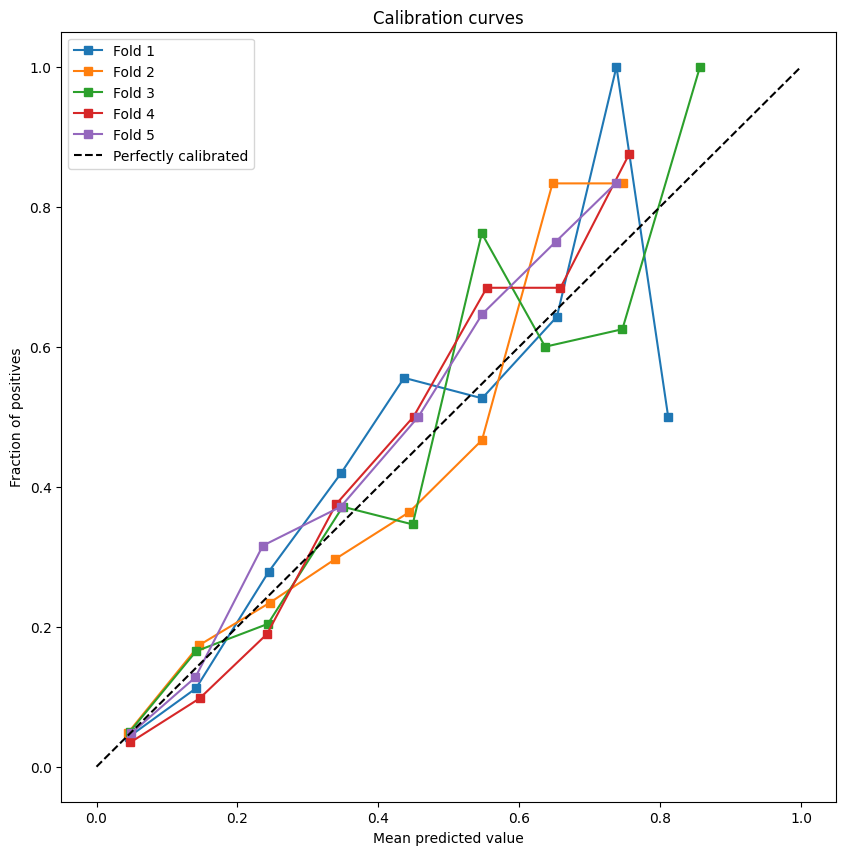

In [23]:
# キャリブレーション曲線の描画
plt.figure(figsize=(10, 10))
for i in range(cv.n_splits):
    plt.plot(mean_predicted_value_list[i], fraction_of_positives_list[i], "s-", label=f"Fold {i+1}")

plt.plot([0, 1], [0, 1], "k--", label="Perfectly calibrated")
plt.xlabel("Mean predicted value")
plt.ylabel("Fraction of positives")
plt.title("Calibration curves")
plt.legend()
plt.show()

In [24]:
threshold = np.median(list_cutoff)

In [25]:
df_train.head()

,id,Age,TypeofContact,DurationOfPitch,Gender,NumberOfPersonVisiting,NumberOfFollowups,NumberOfTrips,Passport,MonthlyIncome,...,PitchSatisfactionScore_5,Designation_AVP,Designation_Executive,Designation_Manager,Designation_Senior_Manager,Designation_VP,MaritalStatus_未婚,MaritalStatus_独身,MaritalStatus_結婚,MaritalStatus_離婚
0,0,1.149804,1,0.065318,0,-1.908669,0.361786,1.038068,1,-1.334334,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,1,1.767393,0,-0.078714,0,-1.908669,0.361786,-0.699052,1,0.647770,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,2,0.236988,1,-0.654845,1,-1.908669,-0.746633,0.459028,0,-1.015239,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,3,-0.188305,1,0.497416,1,-1.908669,-0.746633,-1.278092,0,-0.374678,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,4,0.943941,0,0.353384,1,-1.908669,-0.746633,0.459028,0,-1.274701,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [26]:
df_test.head()


,id,Age,TypeofContact,DurationOfPitch,Gender,NumberOfPersonVisiting,NumberOfFollowups,NumberOfTrips,Passport,MonthlyIncome,...,PitchSatisfactionScore_5,Designation_AVP,Designation_Executive,Designation_Manager,Designation_Senior_Manager,Designation_VP,MaritalStatus_未婚,MaritalStatus_独身,MaritalStatus_結婚,MaritalStatus_離婚
0,3489,0.943941,1,-0.222747,0,-1.908669,0.361786,2.196148,0,1.865111,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,3490,-0.908825,1,-0.366780,1,-1.908669,0.361786,0.459028,1,-0.727539,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,3491,-1.423483,1,-0.798877,1,-1.908669,0.361786,-1.278092,0,-1.254100,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,3492,-1.835208,0,-1.086943,0,-1.908669,0.361786,-1.278092,0,-1.255745,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,3493,0.223421,0,-1.086943,0,-1.908669,0.361786,-1.278092,0,-1.137861,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


0.8230385101796399 0.7189891651655609 0.2949468672477912


In [27]:
threshold = np.median(list_cutoff)
preds_y_proba = np.zeros(len(df_test))
for model in list_models:
    preds_y_proba += model.predict_proba(df_test[model.feature_name_])[:, 1] / len(list_models)
    print(f"Model: {model}, Proba: {preds_y_proba}")  # 予測確率を表示
preds_y = preds_y_proba

Model: LGBMClassifier(bagging_fraction=0.8, bagging_freq=3, feature_fraction=0.4,
               lambda_l1=0.8, lambda_l2=90, learning_rate=0.01, metric='auc',
               n_estimators=3000, num_leaves=20, objective='binary',
               random_seed=0, subsample=0.8, subsample_freq=1, verbose=-1), Proba: [0.02075411 0.0357343  0.04928856 ... 0.11438701 0.03739766 0.00282808]
Model: LGBMClassifier(bagging_fraction=0.8, bagging_freq=3, feature_fraction=0.4,
               lambda_l1=0.8, lambda_l2=90, learning_rate=0.01, metric='auc',
               n_estimators=3000, num_leaves=20, objective='binary',
               random_seed=0, subsample=0.8, subsample_freq=1, verbose=-1), Proba: [0.04090777 0.07622148 0.10150557 ... 0.2379885  0.08206982 0.00629439]
Model: LGBMClassifier(bagging_fraction=0.8, bagging_freq=3, feature_fraction=0.4,
               lambda_l1=0.8, lambda_l2=90, learning_rate=0.01, metric='auc',
               n_estimators=3000, num_leaves=20, objective='binary',
   

In [28]:
count = 5

In [29]:
from datetime import datetime
import pytz
# カウント変数をインクリメント
count += 1
# 日本時間を取得
japan_tz = pytz.timezone('Asia/Tokyo')
now = datetime.now(japan_tz)
timestamp = now.strftime("%Y%m%d_%H%M%S")

file_name = f"/content/drive/MyDrive/Signate/2024summer/simplelightgbmv3_{timestamp}_{count:03d}.csv"
ss[1] = preds_y
ss.to_csv(file_name, header=False, index=False)